# Atividade 3 da Disciplica de Machine Learning
## Alunos - Matrícula: 
    Gabriel Miranda - 202100011430
    Rafael Takeguma - 202100011833
    Arthur Santos   - 202000012560
## Etapa 1: Pré-processamento dos dados

Abrindo o dataset em um dataframe pandas

In [1]:
import pandas as pd

df = pd.read_csv("dataset.csv")
df.head()

,curriculum_id,student_id,centro,department_name,course_name,student_age_at_initial_period,birthday,birth_place,ingress_form,locks_number,...,optative_ch_progress,curriculum_status,leaving_reason,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
0,122,97,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,30,1964-05-14,PORTO ALEGRE/RS,TRANSFERÊNCIA COMPULSÓRIA,0,...,100.0,CANCELADO,DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO,1.79,4.537049,0.300,0.476704,0.300,0.530138,0.1611
1,215,167,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1980-05-11,ARACAJU/SE,VESTIBULAR,0,...,100.0,CANCELADO,ABANDONO,6.69,4.537049,0.300,0.476704,0.367,0.530138,0.7366
2,348,285,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,19,1983-10-26,ARACAJU/SE,VESTIBULAR,0,...,100.0,CANCELADO,ABANDONO,6.66,4.537049,0.300,0.476704,0.446,0.530138,0.8911
3,352,289,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,21,1981-08-08,RIO DE JANEIRO/RJ,VESTIBULAR,0,...,100.0,CANCELADO,ABANDONO,6.71,4.537049,0.300,0.476704,0.411,0.530138,0.8273
4,414,351,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1986-02-10,ARACAJU/SE,VESTIBULAR,0,...,100.0,CONCLUÍDO,CONCLUÍDO,6.55,4.537049,0.325,0.476704,0.429,0.530138,0.9132


Exibindo informações gerais sobre o dataset

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   curriculum_id                  2603 non-null   int64  
 1   student_id                     2603 non-null   int64  
 2   centro                         2603 non-null   object 
 3   department_name                2603 non-null   object 
 4   course_name                    2603 non-null   object 
 5   student_age_at_initial_period  2603 non-null   int64  
 6   birthday                       2603 non-null   object 
 7   birth_place                    2600 non-null   object 
 8   ingress_form                   2603 non-null   object 
 9   locks_number                   2603 non-null   int64  
 10  required_ch_progress           2603 non-null   float64
 11  optative_ch_progress           2603 non-null   float64
 12  curriculum_status              2603 non-null   o

Foi observado que a coluna leaving_reason, que descreve o motivo de saída do curso, possui linhas vazias. Como essa coluna foi escolhida para ser a coluna de predição, já que descreve se o aluno saiu por conclusão, abandono, etc., as linhas em que não haviamc onteúdo foram removidas.

In [3]:
# df = df.dropna()
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   curriculum_id                  2603 non-null   int64  
 1   student_id                     2603 non-null   int64  
 2   centro                         2603 non-null   object 
 3   department_name                2603 non-null   object 
 4   course_name                    2603 non-null   object 
 5   student_age_at_initial_period  2603 non-null   int64  
 6   birthday                       2603 non-null   object 
 7   birth_place                    2600 non-null   object 
 8   ingress_form                   2603 non-null   object 
 9   locks_number                   2603 non-null   int64  
 10  required_ch_progress           2603 non-null   float64
 11  optative_ch_progress           2603 non-null   float64
 12  curriculum_status              2603 non-null   o

Exibindo todas as classes da coluna leaving_reason.

In [4]:
df['leaving_reason'].unique()

array(['DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO', 'ABANDONO',
       'CONCLUÍDO',
       'Não atendeu à convocação para o Cadastro Específico conforme Edital 21/2017/PROGRAD',
       'CANCELAMENTO ESPONTÂNEO', 'CANC.. NOVO VESTIBULAR',
       'Transferência Interna', nan, 'TRANSF.P/OUTRA IES',
       'CADASTRO CANCELADO', 'NÃO CONFIRMAÇÃO VÍNCULO'], dtype=object)

A classe 'ABANDONO', na coluna 'leaving_reason', é o que define se há ou não evasão, as restantes não representam a evasão. 

Logo, vamos gerar uma nova coluna de classe com o nome de 'abandono', onde terá valor 1, caso haja evasão (ABANDONO) e 0 caso seja qualquer outro leaving_reason.
Essa será a nossa nova coluna com as classes de predição, portanto removeremos a antiga coluna 'leaving_reason'. 

In [5]:
df['abandono'] = df['leaving_reason'].isin(['ABANDONO']).astype('int8')
df = df.drop(columns=['leaving_reason'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   curriculum_id                  2603 non-null   int64  
 1   student_id                     2603 non-null   int64  
 2   centro                         2603 non-null   object 
 3   department_name                2603 non-null   object 
 4   course_name                    2603 non-null   object 
 5   student_age_at_initial_period  2603 non-null   int64  
 6   birthday                       2603 non-null   object 
 7   birth_place                    2600 non-null   object 
 8   ingress_form                   2603 non-null   object 
 9   locks_number                   2603 non-null   int64  
 10  required_ch_progress           2603 non-null   float64
 11  optative_ch_progress           2603 non-null   float64
 12  curriculum_status              2603 non-null   o

Agora devemos observar o restante das colunas.
Exibindo um resumo das colunas numéricas do dataset.

In [6]:
df.describe()

,curriculum_id,student_id,student_age_at_initial_period,locks_number,required_ch_progress,optative_ch_progress,mc,course_mc,iepl,course_iepl,iech,course_iech,iea,abandono
count,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000
mean,2550.522474,2264.339608,21.346523,0.189013,41.998412,35.592174,4.591375,4.591701,0.481905,0.481732,0.533404,0.533136,1.881360,0.280446
std,869.011702,819.279402,4.983348,0.451748,35.764006,40.494838,2.577844,0.065713,0.212009,0.018498,0.235817,0.011263,2.129704,0.449303
min,122.000000,55.000000,16.000000,0.000000,0.000000,0.000000,0.000000,4.537049,0.300000,0.461930,0.300000,0.521000,0.000000,0.000000
25%,1920.500000,1642.500000,18.000000,0.000000,9.210526,0.000000,2.670000,4.537049,0.300000,0.461930,0.300000,0.521000,0.240750,0.000000
50%,2627.000000,2332.000000,19.000000,0.000000,32.926829,14.285714,5.090000,4.586078,0.393000,0.476704,0.478000,0.530138,0.953300,0.000000
75%,3278.500000,2945.500000,22.000000,0.000000,72.051559,78.571429,6.680000,4.697231,0.637000,0.511211,0.737500,0.551049,3.011200,1.000000
max,3925.000000,3589.000000,54.000000,3.000000,100.000000,100.000000,10.000000,4.697231,1.100000,0.511211,1.000000,0.551049,10.329000,1.000000


Inicialmente, removeremos colunas que não se mostram importantes para a predição da evasão, como: matrícula, data de nascimento, local de nascimento, id do estudante, centro e nome do departamento.
Outros campos podem ser removidos posteriormente, depois de análises mais detalhadas.

In [7]:
df = df.drop(columns=['curriculum_id', 'student_id', 'centro', 'department_name', 'birthday', 'birth_place'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   course_name                    2603 non-null   object 
 1   student_age_at_initial_period  2603 non-null   int64  
 2   ingress_form                   2603 non-null   object 
 3   locks_number                   2603 non-null   int64  
 4   required_ch_progress           2603 non-null   float64
 5   optative_ch_progress           2603 non-null   float64
 6   curriculum_status              2603 non-null   object 
 7   mc                             2603 non-null   float64
 8   course_mc                      2603 non-null   float64
 9   iepl                           2603 non-null   float64
 10  course_iepl                    2603 non-null   float64
 11  iech                           2603 non-null   float64
 12  course_iech                    2603 non-null   f

Agora, vamos analisar as colunas numéricas restantes para determinar se precisamos realizar transformações ou remoções de colunas.

In [8]:
colunas_numericas = df.drop(columns=['abandono']).columns
df[colunas_numericas].describe()

,student_age_at_initial_period,locks_number,required_ch_progress,optative_ch_progress,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
count,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000
mean,21.346523,0.189013,41.998412,35.592174,4.591375,4.591701,0.481905,0.481732,0.533404,0.533136,1.881360
std,4.983348,0.451748,35.764006,40.494838,2.577844,0.065713,0.212009,0.018498,0.235817,0.011263,2.129704
min,16.000000,0.000000,0.000000,0.000000,0.000000,4.537049,0.300000,0.461930,0.300000,0.521000,0.000000
25%,18.000000,0.000000,9.210526,0.000000,2.670000,4.537049,0.300000,0.461930,0.300000,0.521000,0.240750
50%,19.000000,0.000000,32.926829,14.285714,5.090000,4.586078,0.393000,0.476704,0.478000,0.530138,0.953300
75%,22.000000,0.000000,72.051559,78.571429,6.680000,4.697231,0.637000,0.511211,0.737500,0.551049,3.011200
max,54.000000,3.000000,100.000000,100.000000,10.000000,4.697231,1.100000,0.511211,1.000000,0.551049,10.329000


Plotando uma scatter matrix (correlação entre as variáveis do dataframe)

array([[<Axes: xlabel='student_age_at_initial_period', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='locks_number', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='required_ch_progress', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='optative_ch_progress', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='mc', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='course_mc', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='iepl', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='course_iepl', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='iech', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='course_iech', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='iea', ylabel='student_age_at_initial_period'>,
        <Axes: xlabel='abandono', ylabel='student_age_at_initial_period'>],
       [<Axes: xlabel='student_age_at_initial_period', ylabel=

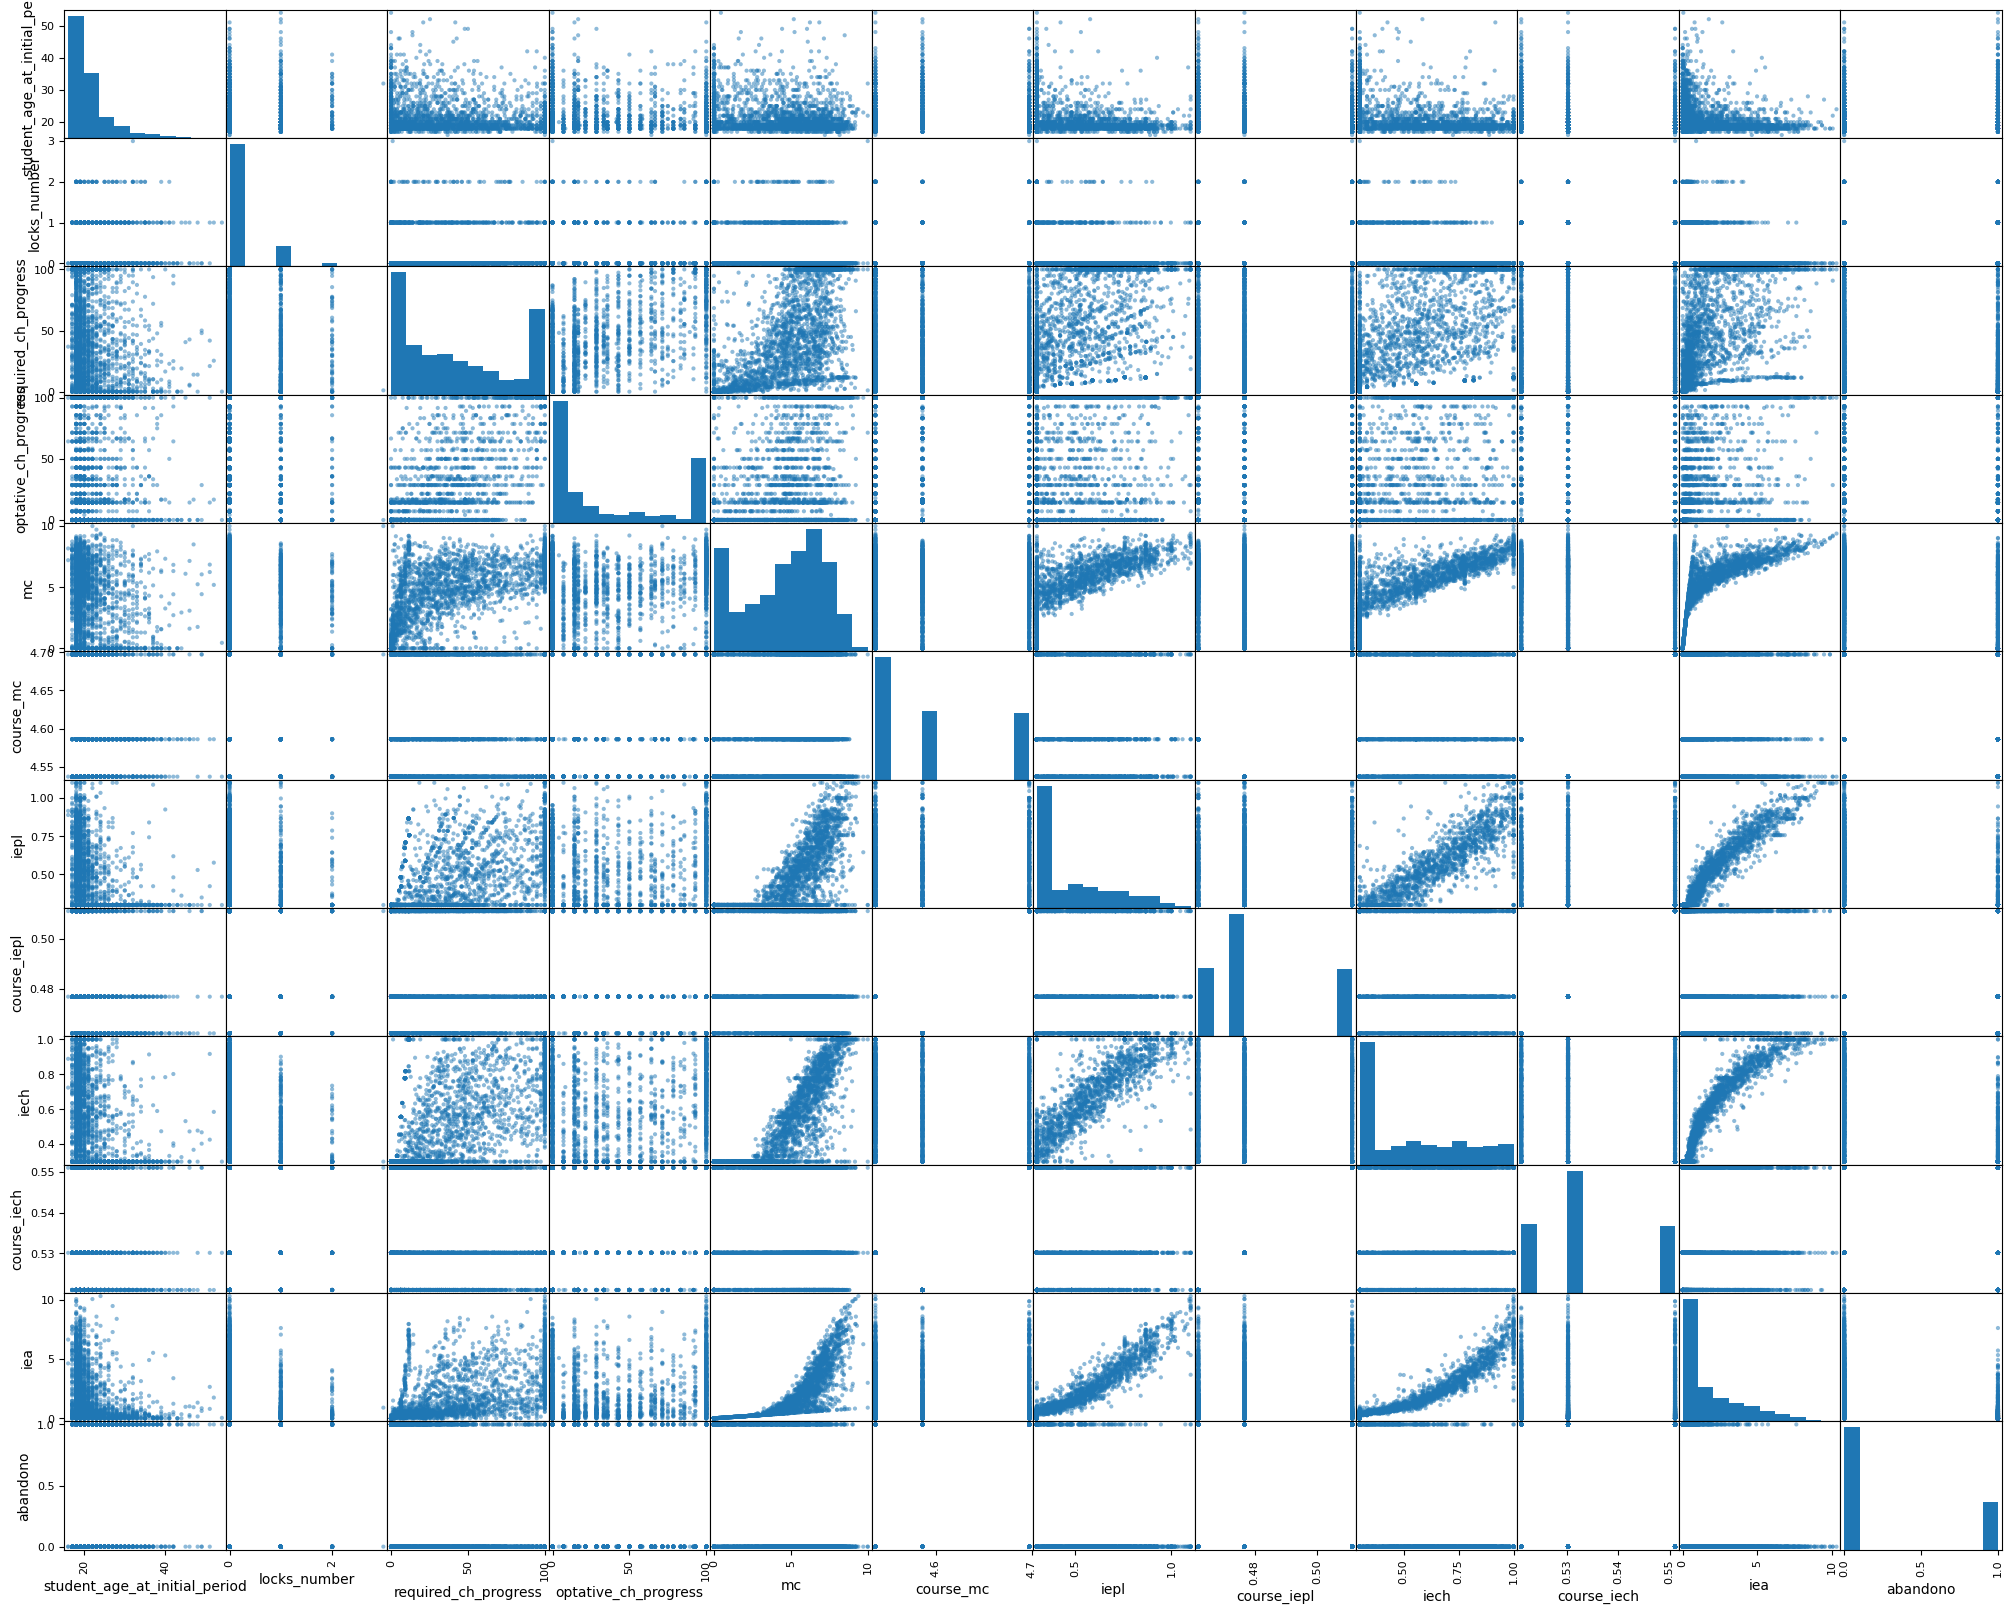

In [9]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, figsize=(25,20))

Através da matriz, podemos visualizar que as variáveis de locks_numer, course_mc, course_iepl e course_iech tem uma correlação muito baixa com a coluna que queremos prever, portanto são boas candidatas a serem eliminadas.

array([[<Axes: xlabel='locks_number', ylabel='locks_number'>,
        <Axes: xlabel='course_mc', ylabel='locks_number'>,
        <Axes: xlabel='course_iepl', ylabel='locks_number'>,
        <Axes: xlabel='course_iech', ylabel='locks_number'>,
        <Axes: xlabel='abandono', ylabel='locks_number'>],
       [<Axes: xlabel='locks_number', ylabel='course_mc'>,
        <Axes: xlabel='course_mc', ylabel='course_mc'>,
        <Axes: xlabel='course_iepl', ylabel='course_mc'>,
        <Axes: xlabel='course_iech', ylabel='course_mc'>,
        <Axes: xlabel='abandono', ylabel='course_mc'>],
       [<Axes: xlabel='locks_number', ylabel='course_iepl'>,
        <Axes: xlabel='course_mc', ylabel='course_iepl'>,
        <Axes: xlabel='course_iepl', ylabel='course_iepl'>,
        <Axes: xlabel='course_iech', ylabel='course_iepl'>,
        <Axes: xlabel='abandono', ylabel='course_iepl'>],
       [<Axes: xlabel='locks_number', ylabel='course_iech'>,
        <Axes: xlabel='course_mc', ylabel='course_iec

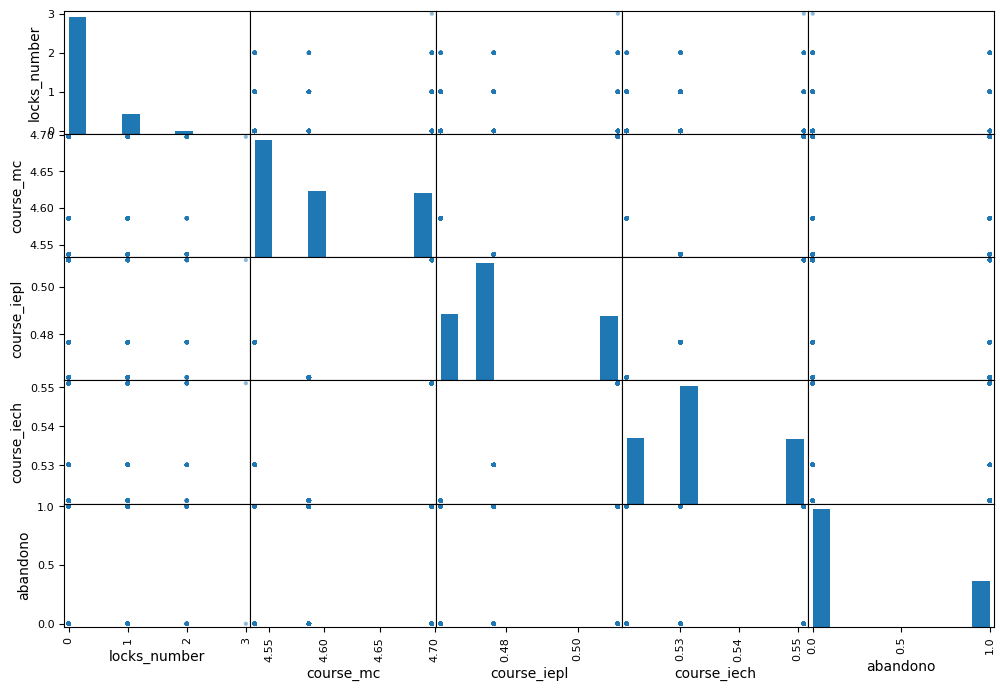

In [10]:
colunas_observadas = ['locks_number', 'course_mc', 'course_iepl', 'course_iech', 'abandono']
scatter_matrix(df[colunas_observadas], figsize=(12,8))

Isolando as variáveis com a coluna de abandono, fica clara a baixa correlação, o que pode atrapalhar o modelo, se esses atributos forem mantidos. Por isso removeremos eles.

In [11]:
df = df.drop(columns=['locks_number', 'course_mc', 'course_iepl', 'course_iech'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   course_name                    2603 non-null   object 
 1   student_age_at_initial_period  2603 non-null   int64  
 2   ingress_form                   2603 non-null   object 
 3   required_ch_progress           2603 non-null   float64
 4   optative_ch_progress           2603 non-null   float64
 5   curriculum_status              2603 non-null   object 
 6   mc                             2603 non-null   float64
 7   iepl                           2603 non-null   float64
 8   iech                           2603 non-null   float64
 9   iea                            2603 non-null   float64
 10  abandono                       2603 non-null   int8   
dtypes: float64(6), int64(1), int8(1), object(3)
memory usage: 206.0+ KB


Agora, utilizamos a função hist() para vizualizar os dados numéricos em forma de histograma.

Dessa forma podemos verificar a distribuição dos dados e suas escalas.

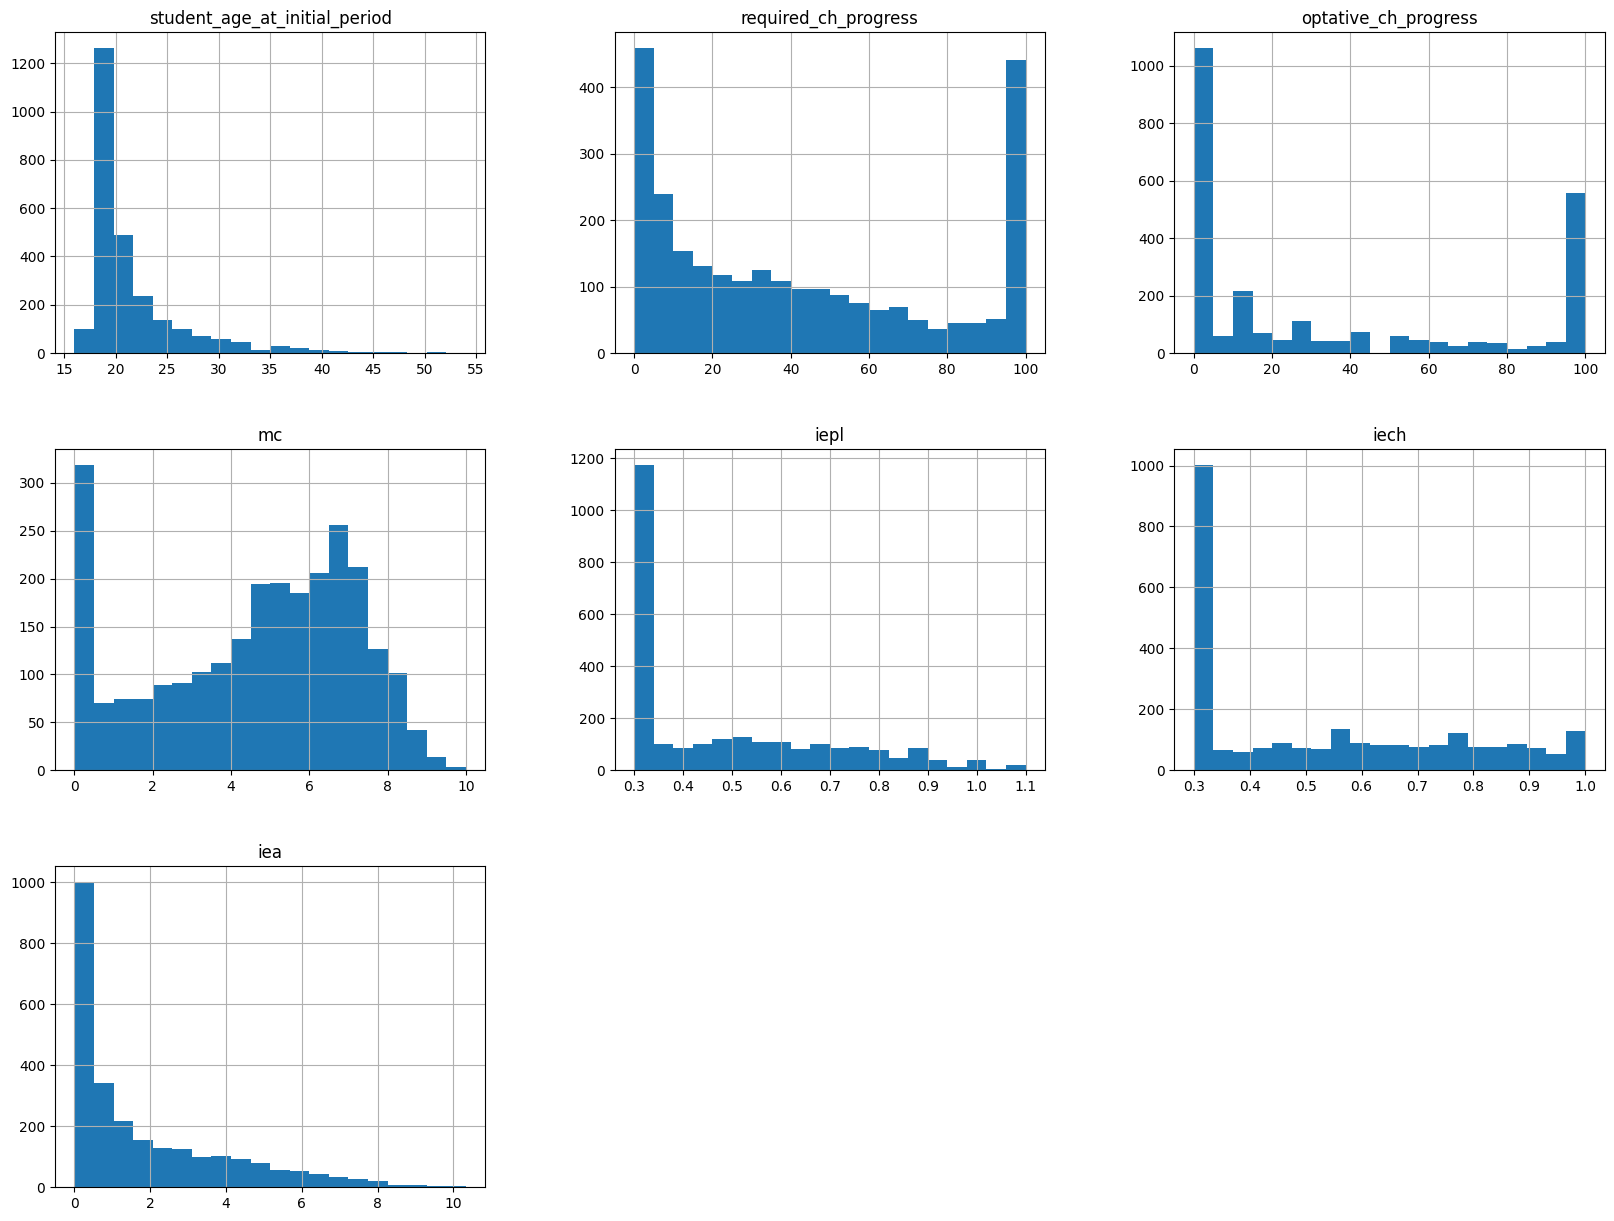

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

colunas_numericas = df.drop(columns=['abandono', 'course_name', 'ingress_form', 'curriculum_status']).columns
df[colunas_numericas].hist(bins=20, figsize=(20,15))
plt.show()

É possível observar que há uma descrepância na escala desses dados. Com o iepl, por exemplo, indo de 0.3 até 1.1 enquanto o required_ch_progress vai de 0 a 100.

Portanto, vamos utilizar o Standard Scaler para padronizá-los.

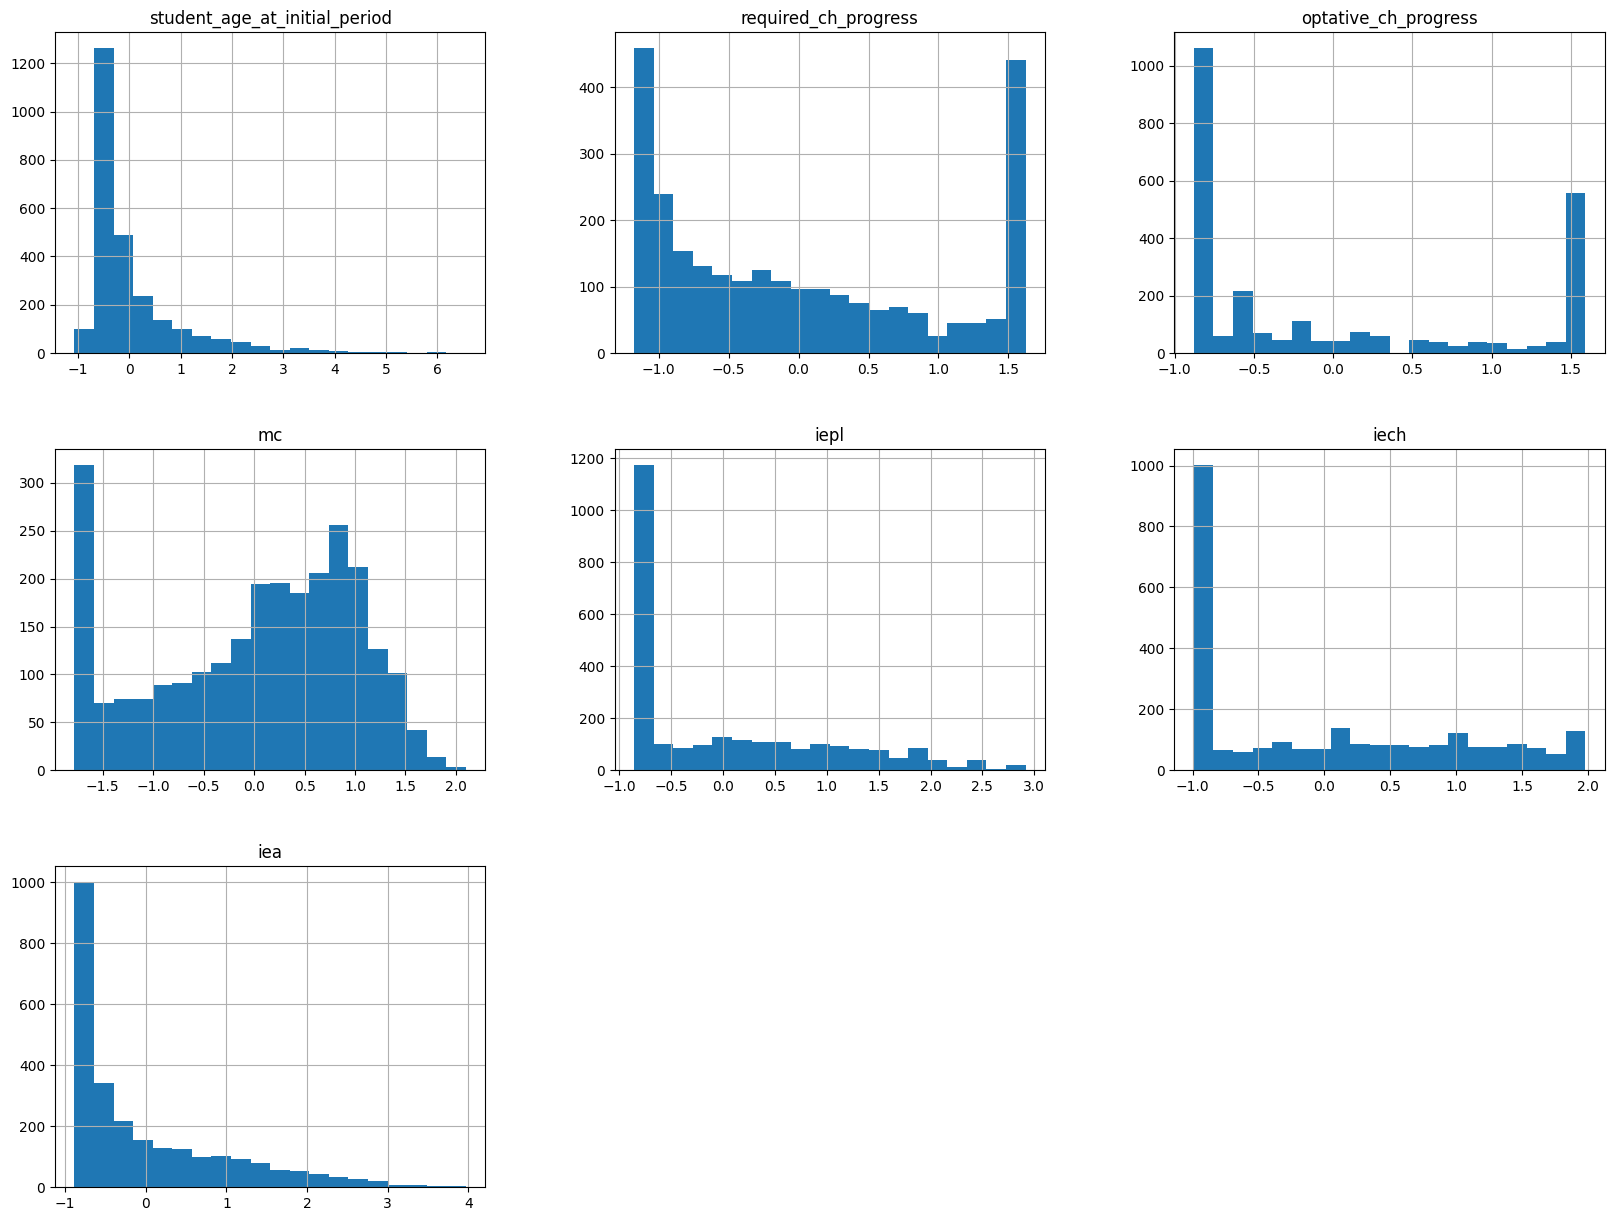

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[colunas_numericas] = scaler.fit_transform(df[colunas_numericas])

df[colunas_numericas].hist(bins=20, figsize=(20,15))
plt.show()

Após a aplicação do Standard Scaler, vemos que as unidades de cada coluna estão muito mais próximas umas das outras, o que tende a melhorar o treinamento e predição do modelo.

Por fim, vamos transformar as colunas object em colunas numéricas para que elas encaixem nos modelos.

In [14]:
df = pd.get_dummies(df, columns=['course_name', 'ingress_form', 'curriculum_status'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   student_age_at_initial_period                  2603 non-null   float64
 1   required_ch_progress                           2603 non-null   float64
 2   optative_ch_progress                           2603 non-null   float64
 3   mc                                             2603 non-null   float64
 4   iepl                                           2603 non-null   float64
 5   iech                                           2603 non-null   float64
 6   iea                                            2603 non-null   float64
 7   abandono                                       2603 non-null   int8   
 8   course_name_CIÊNCIA DA COMPUTAÇÃO              2603 non-null   bool   
 9   course_name_ENGENHARIA DE COMPUTAÇÃO           2603 

### Etapa 2 - Seleção de modelo
Após o pré-processamento, vamos escolher o modelo que melhor se encaixa no problema.

Primeiramente, separamos o dataset em treino e teste, com uma proporção de 80% treino e 20% teste.

In [15]:
from sklearn.model_selection import train_test_split
import random
import numpy as np

# Definir a seed para garantir reprodutibilidade
random.seed(42)  # Seed do Python
np.random.seed(42)  # Seed do NumPy

X = df.drop(columns=['abandono'])
y = df['abandono']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Importando e inicializando os classificadores

In [16]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

rand_forest = RandomForestClassifier(random_state=42)
extra_trees = ExtraTreesClassifier(random_state=42)
kneighbors = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier(random_state=42)

Random Forest Classifier

In [17]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Validação Cruzada:")
scores = cross_val_score(rand_forest, X, y, cv=5)
print(scores)
print("Média da validação cruzada:")
print(scores.mean())

Acurácia: 0.84
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       375
           1       0.69      0.79      0.74       146

    accuracy                           0.84       521
   macro avg       0.80      0.83      0.81       521
weighted avg       0.85      0.84      0.85       521

Validação Cruzada:
[0.71401152 0.82149712 0.80614203 0.79615385 0.74615385]
Média da validação cruzada:
0.7767916728185442


Como pode-se observar o modelo Random Forest Alcançou uma acurácia geral de 84%, ou seja do total de 521 previsões realizadas, 84% estavam corretas. 

A acurácia média na validação cruzada foi 77.68%, ou seja, mais de 6 pontos percentuais pior que a acurácia geral, o que pode indicar um overfitting, pois o modelo teve um desempenho consideravelmente superior no conjunto de teste geral mas não se manteve estável em diferentes divisões dos dados.

Vale lembrar que os dados estão desbalanceados, visto que no conjunto de teste existem 375 instâncias de não evasão e 146 de evasão (coluna 'support'). E a acurácia pode ser enganosa em dados desbalanceados.

A precisão do modelo RF na classificação da classe 'não evasão' foi alta, 91%. Ou seja, de todas as instâncias que o modelo classificou como 'não evasão', 91% delas eram de fato 'não evasão'.

Por outro lado, a precisão na classificação da classe 'evasão' foi bem inferior, 69%. Ou seja, de todas as instâncias que o modelo classificou como 'evasão', apenas 69% delas eram de fato da classe 'evasão'.

Por meio da métrica precisão, já foi possível observar que o desempenho do modelo RF foi bem inferior na classe menos numerosa. Desse modo, torna-se válido testar métodos de balanceamento.

O recall (sensibilidade) também foi maior na classe mais numerosa, 86%. Ou seja, de todas as instâncias 'não evasão' que existem, o modelo conseguiu identificar e classificar com sucesso 86% delas. Já para a classe 'evasão' esse número cai para 79%.

Naturalmente, como o conjunto de dados está desbalanceado os resultados das médias macro estão piores que as médias ponderadas, da qual atribui maior peso às classes mais numerosas (maior support), como o modelo alcançou resultados melhores com elas, a Weighted Average também será maior.

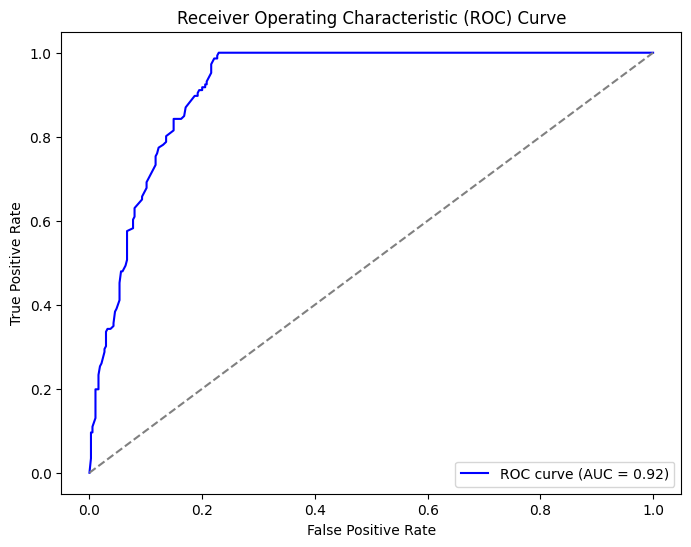

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_scores = rand_forest.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

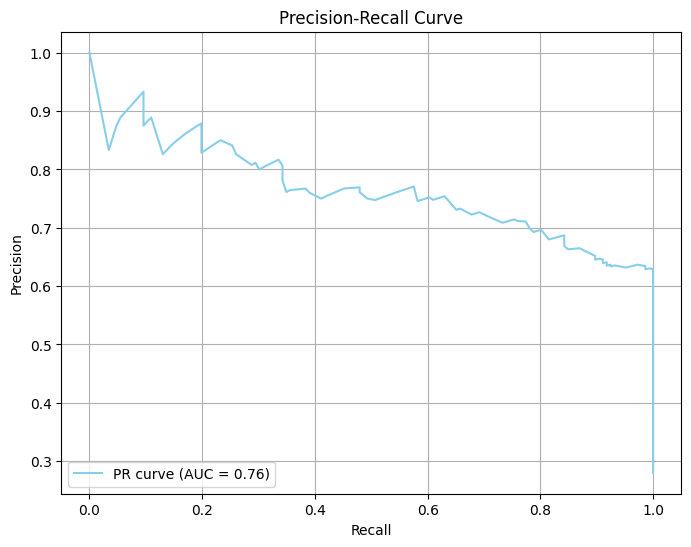

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = rand_forest.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

# Plotar a curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='skyblue', label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

A curva Precision-Recall é uma alternativa para a curva ROC quando lidamos com um conjunto de dados assimétrico (DAVIS; GOADRICH, 2006).

A curva de Precision-Recall ideal toparia o canto superior direito, onde teríamos um 100% de precisão e identificaríamos 100% das classes positivas. Ou seja, em um cenário realista, quanto mais perto do canto superior direito melhor.

Um comportamento natural para essa curva é a precisão diminuir à medida que o recall aumenta, pois se o modelo se esforça para identificar todas as 'evasões' ele pode acabar cometendo erros e ficar menos preciso.

Extra Trees Classifier

In [18]:
extra_trees.fit(X_train, y_train)
y_pred = extra_trees.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Validação Cruzada:")
scores = cross_val_score(extra_trees, X, y, cv=5)
print(scores)
print("Média da validação cruzada:")
print(scores.mean())

Acurácia: 0.84
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       375
           1       0.68      0.80      0.74       146

    accuracy                           0.84       521
   macro avg       0.80      0.83      0.81       521
weighted avg       0.85      0.84      0.84       521

Validação Cruzada:
[0.71401152 0.81765835 0.80038388 0.77115385 0.73269231]
Média da validação cruzada:
0.7671799793296914


KNeighbors Classifier

In [19]:
kneighbors.fit(X_train, y_train)
y_pred = kneighbors.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Validação Cruzada:")
scores = cross_val_score(kneighbors, X, y, cv=5)
print(scores)
print("Média da validação cruzada:")
print(scores.mean())

Acurácia: 0.83
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       375
           1       0.68      0.78      0.73       146

    accuracy                           0.83       521
   macro avg       0.79      0.82      0.80       521
weighted avg       0.84      0.83      0.84       521

Validação Cruzada:
[0.70441459 0.84452975 0.81573896 0.78269231 0.74807692]
Média da validação cruzada:
0.7790905064225602


Decision Tree Classifier

In [20]:
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Validação Cruzada:")
scores = cross_val_score(decision_tree, X, y, cv=5)
print(scores)
print("Média da validação cruzada:")
print(scores.mean())

Acurácia: 0.81
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       375
           1       0.65      0.69      0.67       146

    accuracy                           0.81       521
   macro avg       0.76      0.77      0.77       521
weighted avg       0.81      0.81      0.81       521

Validação Cruzada:
[0.74856046 0.81957774 0.80806142 0.78846154 0.75192308]
Média da validação cruzada:
0.7833168463014911


Analisando os resultados de cada modelo, escolhemos o ExtraTreesClassifier como modelo final.